In [3]:
import utils
import algs
import importlib


import pandas as pd
import numpy as np
import random
import torch
import gurobipy
import cvxpy as cp
import matplotlib.pyplot as plt
import pickle as pkl

from sodapy import Socrata
from datetime import datetime, timedelta



# Run Experiments

In [ ]:
# values in meters
# Distance threshold that determines if two vertices are connected by an edge
THRESH = 250  

# Radius where vertices are randomly perturbed
RADIUS = 1000

R_range = [0.0, 0.15, 0.30, 0.45, 0.60, 0.75]

p_range = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25,0.3, 0.35, 0.4, 0.45, 0.5]


RC_pairs = []

num_trials = 2
raw_data = []
for j in range(num_trials):
    print(j)
    
    ## Get data from Chicago API and create graph from it
    D1_df, D2_df_list, S_df = utils.get_data(limit=100)

    D1_df = D1_df.sample(n=int(len(D1_df)/2))
    for k in range(len(D2_df_list)):
        D2_df_list[k] = D2_df_list[k].sample(n=int(len(D2_df_list[k])/2))

    edges1, edges2, edges2_list, _, coordinate_info = utils.create_graph(D1_df, D2_df_list, S_df, thresh=THRESH, radius=RADIUS)

    D1 = set([e[0] for e in edges1])
    S = set([e[1] for e in edges1] + [e[1] for e in utils.flatten(edges2_list)])
    
    # Define the weight distributions
    weights_dict = {}
    unweighted = {j: 1 for j in S}
    unif_1 = {j: np.random.uniform(1,1.5) for j in S}
    unif_2 = {j: np.random.uniform(1,2.0) for j in S}
    unif_3 = {j: np.random.uniform(1,3.0) for j in S}
    unif_4 = {j: np.random.uniform(1,4.0) for j in S}
    abs_normal = {j: np.abs(np.random.normal(0,1.0)) for j in S}

    weights_dict = {
        'unweighted': unweighted,
        'unif_1.5': unif_1,
        'unif_2.0': unif_2,
        'unif_3.0': unif_3,
        'unif_4.0': unif_4,
        'normal': abs_normal
    }
    
    data = {}
    
    for key in weights_dict:
        weights = weights_dict[key]
        
        
        d = {}

    
        ## Generate suggested matching A
        sugg, sugg_edges = algs.best_suggested_matching(edges1, edges2, weights, verbose=False)

        ## Our algorithm's value, ALG(G, A)
        for p in p_range:        
            ## Corrupt the suggested matching by randomly reassigning each edge with probability p
            corrupted_matching = utils.corrupt_advice(edges1, sugg_edges, p=p)
            corrupted_sugg = [e[1] for e in corrupted_matching]
            assert(len(corrupted_sugg) == len(set(corrupted_sugg)))

            for R in R_range:

                our_value = algs.our_alg(edges1, edges2, corrupted_sugg, weights, R, verbose=False)

                d[(str(R), str(p))] = our_value

        ## Optimal hindsight value, OPT(G)
        opt_value = algs.opt(edges1, edges2, weights, verbose=False)
        d['opt'] = opt_value

        ## Value if advice follwed exactly, ADVICE(G, A)
        advice_value = algs.advice(edges1, edges2, sugg, weights, verbose=False)
        d['advice'] = advice_value

        ## Run greedy 
        greedy_value = algs.greedy(edges1, edges2, weights, verbose=False)
        d['greedy'] = greedy_value
        
        ## Run fully robust
        robust_value = algs.fully_robust(edges1, edges2, weights, verbose=False)
        d['robust'] = robust_value

        ## Calculate metrics
        robustness = our_value / opt_value
        consistency = our_value / advice_value
        
        data[key] = d

    raw_data.append(data)

0
Using license file /Users/Prince/gurobi.lic
Academic license - for non-commercial use only


# Plot the Competitive Ratios

['unweighted']


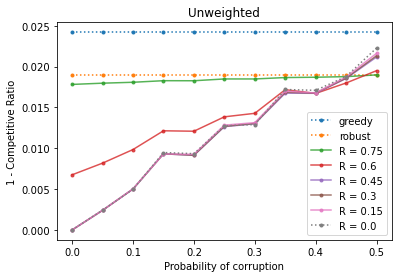

['unif_1.5']


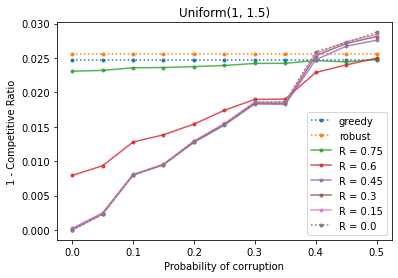

['unif_2.0']


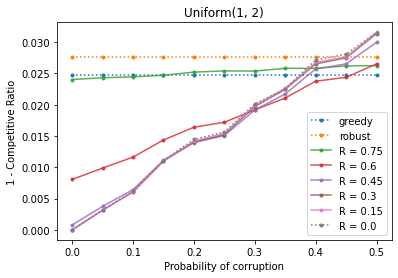

['unif_3.0']


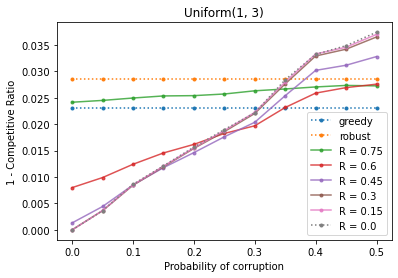

['unif_4.0']


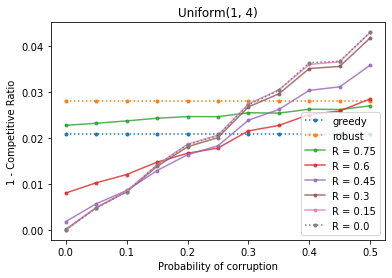

['normal']


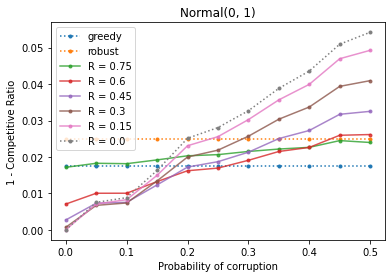

In [14]:
keys = raw_data[0].keys()

titlemap = {
    'unweighted': "Unweighted",
    'unif_1.5': 'Uniform(1, 1.5)',
    'unif_2.0': 'Uniform(1, 2)',
    'unif_3.0': 'Uniform(1, 3)',
    'unif_4.0': 'Uniform(1, 4)',
    'normal': 'Normal(0, 1)'
}


for key in keys:
    raw_crs2 = utils.crs2(raw_data, keys=[key])
    utils.plot_crs(raw_crs2, title=titlemap[key], savefig=True)

# Visualize the Locations

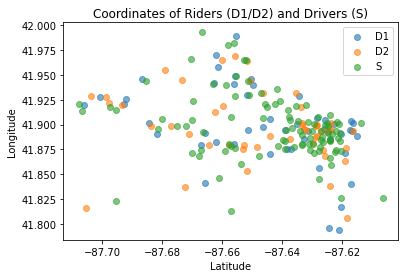

In [8]:
D1_coords, D2_coords, S_coords = coordinate_info['D1'], coordinate_info['D2'], coordinate_info['S']
utils.visualize(D1_coords, D2_coords, S_coords, savefig=False)
